# SWaT 오픈 데이터셋을 이용한 LSTM 학습

## 라이브러리 import + 설정

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 재현성

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 파일 경로 지정

In [2]:
NORMAL_CSV = r"C:\ai_dev\jupyter\test\swat\dataset\normal.csv"
ATTACK_CSV = r"C:\ai_dev\jupyter\test\swat\dataset\attack.csv"

assert os.path.exists(NORMAL_CSV), "NORMAL_CSV 경로 틀림"
assert os.path.exists(ATTACK_CSV), "ATTACK_CSV 경로 틀림"
print("OK")

OK


## CSV 로드 + Timestamp 파싱 + 라벨컬럼 

In [3]:
def load_swat_csv(path: str):
    df = pd.read_csv(path)

    # Timestamp 컬럼명 정리 (공백/대소문자 대비)
    # 보통 'Timestamp' 그대로인데 혹시 몰라서 방어
    ts_candidates = [c for c in df.columns if c.strip().lower() == "timestamp"]
    assert len(ts_candidates) == 1, f"Timestamp 컬럼을 못 찾음: {ts_candidates}"
    ts_col = ts_candidates[0]

    # 날짜 포맷: 28/12/2015 10:29:14 AM (일/월/년)
    df[ts_col] = pd.to_datetime(df[ts_col], dayfirst=True, errors="coerce")
    df = df.dropna(subset=[ts_col]).sort_values(ts_col).reset_index(drop=True)

    # 라벨 컬럼: 보통 마지막에 'Normal/Attack'
    label_candidates = [c for c in df.columns if "normal" in c.lower() and "attack" in c.lower()]
    if len(label_candidates) == 0:
        # 못 찾으면 마지막 컬럼을 라벨로 가정 (데이터셋 구조상 마지막 컬럼이 normal/attack 이어서)
        label_col = df.columns[-1]
    else:
        label_col = label_candidates[0]

    return df, ts_col, label_col

df_normal, ts_col, label_col = load_swat_csv(NORMAL_CSV)
df_attack, ts_col2, label_col2 = load_swat_csv(ATTACK_CSV)

assert ts_col == ts_col2
assert label_col == label_col2
print("Timestamp:", ts_col)
print("Label:", label_col)
print(df_normal.shape, df_attack.shape)
df_normal.head(2)


Timestamp:  Timestamp
Label: Normal/Attack
(1387093, 53) (54621, 53)


,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,2015-12-22 16:00:00,2.470294,261.5804,NaN,2,1,NaN,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,2015-12-22 16:00:01,2.457163,261.1879,NaN,2,1,NaN,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


## Feature 컬럼 선택 + 라벨 정리

In [4]:
# feature = Timestamp, 라벨 제외한 나머지 전부
feature_cols = [c for c in df_normal.columns if c not in [ts_col, label_col]]

# 혹시 숫자 아닌 컬럼이 섞여 있으면 제거
numeric_feature_cols = []
for c in feature_cols:
    if pd.api.types.is_numeric_dtype(df_normal[c]):
        numeric_feature_cols.append(c)

feature_cols = numeric_feature_cols
print("num_features:", len(feature_cols))

# 라벨을 0/1로
def label_to_binary(s):
    # "Normal" -> 0, "Attack" -> 1
    s = str(s).strip().lower()
    return 1 if "attack" in s else 0

df_normal["y"] = df_normal[label_col].apply(label_to_binary)
df_attack["y"] = df_attack[label_col].apply(label_to_binary)

# Normal 파일은 보통 다 0이어야 정상
print("normal y counts:", df_normal["y"].value_counts().to_dict())
print("attack y counts:", df_attack["y"].value_counts().to_dict())


num_features: 51
normal y counts: {0: 1387093}
attack y counts: {1: 54621}


## 결측 처리 + 스케일링 (train=normal 기준으로 fit)

In [5]:
# 결측 보간(센서 결측 대응): 앞/뒤로 채우고 남은 건 0
def clean_features(df):
    x = df[feature_cols].copy()
    x = x.replace([np.inf, -np.inf], np.nan)
    x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
    return x

X_train_raw = clean_features(df_normal)
X_test_raw  = clean_features(df_attack)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw.values)
X_test  = scaler.transform(X_test_raw.values)

print(X_train.shape, X_test.shape)

C:\Users\bizforce\AppData\Local\Temp\ipykernel_9252\4250394568.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)
C:\Users\bizforce\AppData\Local\Temp\ipykernel_9252\4250394568.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = x.fillna(method="ffill").fillna(method="bfill").fillna(0.0)


(1387093, 51) (54621, 51)


## Cell 5) 슬라이딩 윈도우 Dataset (10초 샘플 기준 윈도우 추천 포함)
### 10초마다 1개니까
- 10분 = 60포인트
- 30분 = 180포인트
- 1시간 = 360포인트
### 일단 30분(180)으로 시작

In [10]:
SEQ_LEN = 180   # 30분 윈도우 (10초*180=1800초=30분)
STRIDE  = 1

class SlidingWindowDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray=None, seq_len=180, stride=1):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64) if y is not None else None
        self.seq_len = seq_len
        self.stride = stride

        self.starts = list(range(0, len(self.X) - seq_len + 1, stride))

    def __len__(self):
        return len(self.starts)

    def __getitem__(self, idx):
        s = self.starts[idx]
        e = s + self.seq_len
        x_seq = self.X[s:e]  # (seq, feat)

        if self.y is None:
            return torch.from_numpy(x_seq)

        # 윈도우 구간에 Attack이 하나라도 있으면 1 (윈도우 레벨 라벨)
        y_win = 1 if self.y[s:e].max() > 0 else 0
        return torch.from_numpy(x_seq), torch.tensor(y_win)

y_train = df_normal["y"].values
y_test  = df_attack["y"].values

train_ds = SlidingWindowDataset(X_train, y=None, seq_len=SEQ_LEN, stride=STRIDE)
test_ds  = SlidingWindowDataset(X_test,  y_test,  seq_len=SEQ_LEN, stride=STRIDE)

len(train_ds), len(test_ds)


(1386914, 54442)

## DataLoader

In [11]:
BATCH_SIZE = 64  # 4070 8GB면 보통 이 정도는 안정권
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


## LSTM AutoEncoder 모델

In [12]:
class LSTMAutoEncoder(nn.Module):
    def __init__(self, n_features, hidden_size=128, num_layers=1, dropout=0.0):
        super().__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Encoder: seq -> last hidden
        self.encoder = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # Decoder: repeat latent -> seq
        self.decoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.output_layer = nn.Linear(hidden_size, n_features)

    def forward(self, x):
        # x: (B, T, F)
        B, T, F = x.shape

        _, (h_n, _) = self.encoder(x)     # h_n: (L, B, H)
        latent = h_n[-1]                  # (B, H)

        dec_in = latent.unsqueeze(1).repeat(1, T, 1)  # (B, T, H)
        dec_out, _ = self.decoder(dec_in)             # (B, T, H)
        x_hat = self.output_layer(dec_out)            # (B, T, F)
        return x_hat

n_features = len(feature_cols)
model = LSTMAutoEncoder(n_features=n_features, hidden_size=128, num_layers=1).to(device)

criterion = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model


LSTMAutoEncoder(
  (encoder): LSTM(51, 128, batch_first=True)
  (decoder): LSTM(128, 128, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=51, bias=True)
)

## 학습 루프 (AMP 옵션 포함)

In [13]:
EPOCHS = 10
use_amp = (device.type == "cuda")
scaler_amp = torch.cuda.amp.GradScaler(enabled=use_amp)

def train_one_epoch(model, loader):
    model.train()
    losses = []
    for x in loader:
        x = x.to(device)  # (B,T,F)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=use_amp):
            x_hat = model(x)
            loss = criterion(x_hat, x)

        scaler_amp.scale(loss).backward()
        scaler_amp.step(optimizer)
        scaler_amp.update()

        losses.append(loss.item())
    return float(np.mean(losses))

for epoch in range(1, EPOCHS + 1):
    loss = train_one_epoch(model, train_loader)
    print(f"Epoch {epoch:02d} | train_loss = {loss:.6f}")


Epoch 01 | train_loss = 0.094755
Epoch 02 | train_loss = 0.062136
Epoch 03 | train_loss = 0.057120
Epoch 04 | train_loss = 0.054456
Epoch 05 | train_loss = 0.052686
Epoch 06 | train_loss = 0.050685
Epoch 07 | train_loss = 0.048602
Epoch 08 | train_loss = 0.047948
Epoch 09 | train_loss = 0.046816
Epoch 10 | train_loss = 0.046333


## Reconstruction error 계산 (윈도우 단위 점수)

In [14]:
@torch.no_grad()
def compute_window_scores(model, loader):
    model.eval()
    scores = []
    labels = []
    for batch in loader:
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            x, y_win = batch
            labels.extend(y_win.numpy().tolist())
        else:
            x = batch

        x = x.to(device)
        x_hat = model(x)

        # 윈도우별 MSE: (B,T,F) -> (B,)
        mse = ((x_hat - x) ** 2).mean(dim=(1,2)).detach().cpu().numpy()
        scores.extend(mse.tolist())

    scores = np.array(scores)
    labels = np.array(labels) if len(labels) > 0 else None
    return scores, labels

train_scores, _ = compute_window_scores(model, DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False))
test_scores,  test_labels = compute_window_scores(model, test_loader)

train_scores[:5], test_scores[:5], (test_labels[:5] if test_labels is not None else None)


(array([0.37009516, 0.36992431, 0.36975759, 0.36958864, 0.36941978]),
 array([0.19280124, 0.19149904, 0.18995252, 0.1883895 , 0.18688822]),
 array([1, 1, 1, 1, 1]))

## Threshold 잡고 탐지 + 간단 평가

In [15]:
# 정상 기반 임계값: 상위 99.5% (필요하면 99.0~99.9 조정)
PCTL = 99.5
threshold = np.percentile(train_scores, PCTL)
threshold

0.3637475974857819

In [16]:
pred = (test_scores > threshold).astype(int)

# 평가 (윈도우 레벨)
tp = int(((pred == 1) & (test_labels == 1)).sum())
tn = int(((pred == 0) & (test_labels == 0)).sum())
fp = int(((pred == 1) & (test_labels == 0)).sum())
fn = int(((pred == 0) & (test_labels == 1)).sum())

precision = tp / (tp + fp + 1e-9)
recall    = tp / (tp + fn + 1e-9)
f1        = 2 * precision * recall / (precision + recall + 1e-9)

print(f"threshold(p{PCTL}) = {threshold:.6f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
print(f"Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")


threshold(p99.5) = 0.363748
TP=44521, FP=0, TN=0, FN=9921
Precision=1.0000, Recall=0.8178, F1=0.8998


## 그래프(점수/임계값/라벨) 눈으로 확인

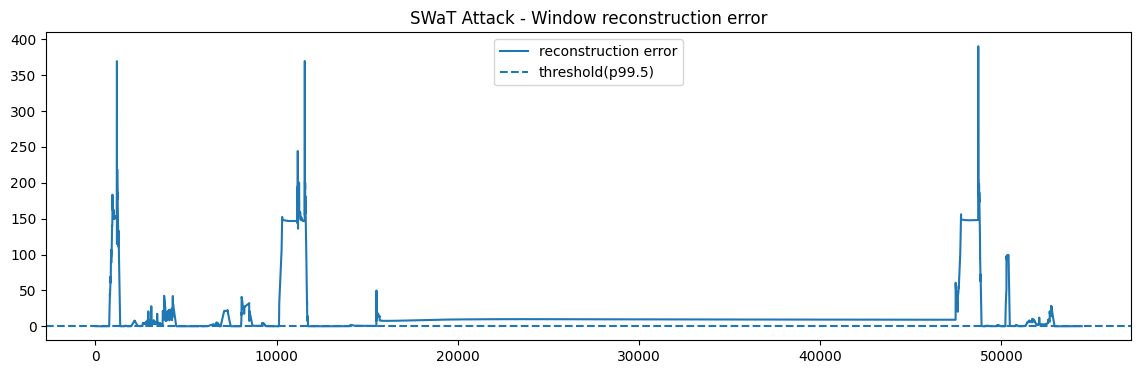

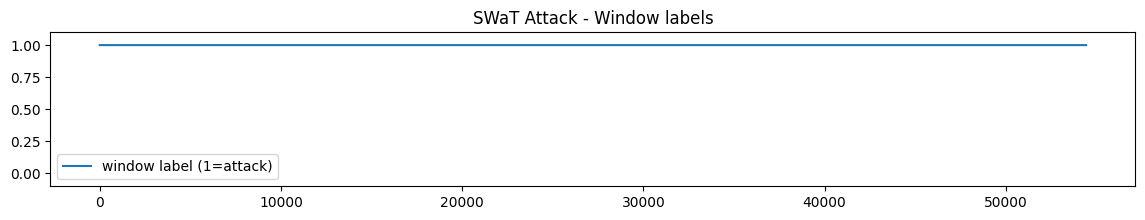

In [17]:
plt.figure(figsize=(14,4))
plt.plot(test_scores, label="reconstruction error")
plt.axhline(threshold, linestyle="--", label=f"threshold(p{PCTL})")
plt.title("SWaT Attack - Window reconstruction error")
plt.legend()
plt.show()

plt.figure(figsize=(14,2))
plt.plot(test_labels, label="window label (1=attack)")
plt.title("SWaT Attack - Window labels")
plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()
